In [1]:
from random import choice, random
import numpy as np
from collections import defaultdict
from statistics import mean
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable

<img src="algorithm.PNG">

In [3]:
class Agent:
    def __init__(self):
        '''
            p - e-мягкая стратегия
            Q - оценка функции ценности. 
            N - подсчет появлений для каждой пары s,a 
            S_A - хранит информацию об эпизоде.
                Действия: 0 - "еще", 1 - "хватит". 
                Состояние зависит от трех факторов (наличие играющего туза (0, 1); 
                                                    открытая карта сдающего (1-10); 
                                                    количество очков (4-21))
        '''
        self.Q = defaultdict(lambda: [0.0, 0.0])
        self.p = defaultdict(lambda: self.policy_init())
        self.N = defaultdict(lambda: [0, 0])
        self.S_A = []
        self.T = 0
        self.d_card = 0

    @staticmethod
    def policy_init():
        choice_0 = random()
        choice_1 = 1-choice_0
        return [choice_0, choice_1]
    
    def start(self, card1, card2, dealer_card):
        
        self.T = 0
        self.S_A = []
        self.d_card = dealer_card
        
        # оценка туза
        if 1 in [card1, card2]:
            self.T = self.playing_T(sum([card1, card2])-1)
            
        # подсчет очков
        points = sum([card1, card2]) + self.T*10
        
        return (self.T, self.d_card, points)
    
    @staticmethod
    def playing_T(points):
        if points + 11 <= 21:
            return 1
        return 0
    
    def action(self, s):
        a = np.random.choice([0, 1], p=self.p[s]) # выбираем action по вероятностям
        self.S_A.append((s, a))
        
        return a
        
    def state(self, points, card):
        
        # оценка туза
        if self.T == 0 and card == 1:
            self.T = self.playing_T(points)
            card += self.T*10

        #подсчет очков
        points += card

        # если перебор, то переоцениваем туза
        if points > 21 and self.T == 1:
            points -= 10
            self.T = 0
            
        return (self.T, self.d_card, points)
                    
    
    def policy_improvement(self, r, e):
        
        S_A_set = set(self.S_A) # для оценки уникальных пар состояние-действие
        for s, a in S_A_set:
            self.N[s][a] += 1
            self.Q[s][a] = self.Q[s][a] + (r - self.Q[s][a])/self.N[s][a] # обновление среднего инкрементно
            A = np.argmax(self.Q[s]) # отбираем лучший action 
            # обновляем стратегию
            if a == A:
                self.p[s][a] = 1 - e + e/len(self.p[s])
                self.p[s][1-a] = e/len(self.p[s])
            else:
                self.p[s][1-a] = 1 - e + e/len(self.p[s])
                self.p[s][a] = e/len(self.p[s])
    
        return self.p

In [4]:
class Dealer:
    def __init__(self):
        '''
            deck - бесконечная колода карт
        '''
        self.deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1] 
        self.T = 0
    
    def card(self, n=1):
        if n == 1:
            return choice(self.deck)
        cards = []
        for i in range(n):
            cards.append(choice(self.deck))
        return cards
    
    @staticmethod
    def playing_T(points):
        if points + 11 <= 21:
            return 1
        return 0
    
    def start(self, card1_d, card2_d):
        
        self.T = 0
        # оценка туза
        if 1 in [card1_d, card2_d]:
            self.T = self.playing_T(sum([card1_d, card2_d])-1)
            
        # подсчет очков
        points = sum([card1_d, card2_d]) + self.T*10
        
        return points
    
    @staticmethod
    def action(points):
        # дилер берет карты пока не наберется более 17 очков включительно
        if points < 17:
            return 0
        return 1
    
    def points(self, points, card):
        
        # оценка туза
        if self.T == 0 and card == 1:
            self.T = self.playing_T(points)
            card += self.T*10

        #подсчет очков
        points += card

        # если перебор, то переоцениваем туза
        if points > 21 and self.T == 1:
            points -= 10
            self.T = 0
            
        return points
    
    @staticmethod
    def reward(points, p_dealer):
        
        if points > 21:
            return -1 
        if p_dealer > 21:
            return 1
        if points > p_dealer:
            return 1
        if points < p_dealer:
            return -1
        return 0 

In [5]:
agent = Agent()
dealer = Dealer()
e = 0.15

In [6]:
for _ in tqdm(range(3000000)):
    card1_d, card2_d = dealer.card(2)
    card1_a, card2_a = dealer.card(2)
    s = agent.start(card1_a, card2_a, card1_d)
    d_points = dealer.start(card1_d, card2_d)
    points = s[2]
    a = agent.action(s)
    while a == 0:
        card = dealer.card()
        s = agent.state(points, card)
        points = s[2]
        if points > 21:
            break
        a = agent.action(s)
    if a == 1:
        d_a = dealer.action(d_points)
        while d_a == 0:
            card = dealer.card()
            d_points = dealer.points(d_points, card)
            d_a = dealer.action(d_points)
    r = dealer.reward(points, d_points)
    p = agent.policy_improvement(r, e)
policy = dict((k,np.argmax(v)) for k, v in agent.Q.items())

In [7]:
V = {}

for state, actions_s in dict(agent.Q).items():
    V[state] = actions_s[policy[state]]

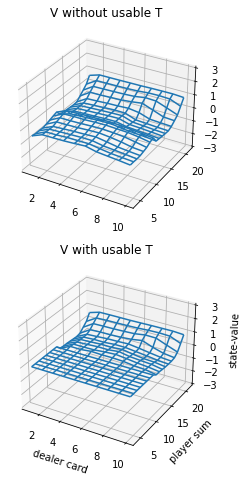

In [8]:
def plot_blackjack(V, ax1, ax2):
    points = np.arange(4, 21 + 1)
    dealer_card = np.arange(1, 10 + 1)
    playing_T = np.array([0, 1])
    state_values = np.zeros((len(playing_T), len(dealer_card), len(points)))
    for key in V.keys():
        state_values[key[0], (key[1]-1), (key[2]-4)] = V[key]
    Y, X = np.meshgrid(points, dealer_card)
    ax1.plot_wireframe(X, Y, state_values[0, :, :])
    ax2.plot_wireframe(X, Y, state_values[1, :, :])
    for ax in ax1, ax2:
        ax.set_zlim(-3, 3)
    ax.set_xlabel("dealer card")
    ax.set_ylabel("player sum")
    ax.set_zlabel("state-value")
fig, axes = plt.subplots(nrows=2, figsize=(5, 8),subplot_kw={'projection': '3d'})
axes[0].set_title('V without usable T')
axes[1].set_title('V with usable T')
plot_blackjack(V, axes[0], axes[1])

In [9]:
actions1, actions0 = np.zeros((22,11)), np.zeros((22,11))
actions1[...], actions0[...] = -1, -1
for state, action in dict(policy).items():
    if state[0] == 0:
        actions0[state[2], state[1]] = action
    else:
        actions1[state[2], state[1]] = action
actions0 = actions0[::-1]
actions1 = actions1[::-1]

(4.0, 22.0)

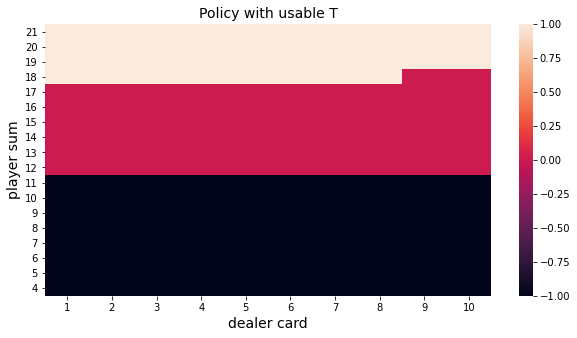

In [10]:
_, axes = plt.subplots(figsize=(10, 5))
fig = sns.heatmap(np.flipud(actions1))
fig.set_xlabel('dealer card', fontsize=14)
fig.set_ylabel('player sum', fontsize=14)
fig.set_title('Policy with usable T', fontsize=14)
plt.xlim(1, 11)
plt.ylim(4, 22)

(4.0, 22.0)

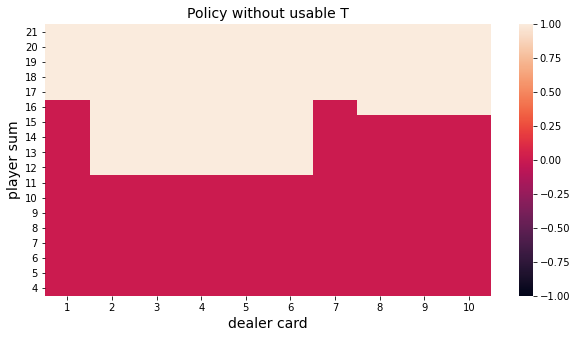

In [11]:
_, axes = plt.subplots(figsize=(10, 5))
fig = sns.heatmap(np.flipud(actions0))
fig.set_xlabel('dealer card', fontsize=14)
fig.set_ylabel('player sum', fontsize=14)
fig.set_title('Policy without usable T', fontsize=14)
plt.xlim(1, 11)
plt.ylim(4, 22)